In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from patsy import dmatrices
import math

#  Анализ изменения весомости (NWOE) и информационной ценности (NIV) признаков для оценки эффекта воздействия ATE 

###  Цель исследований

   Целью исследований является оценка цеености признаков и степени их влияния на достижение положительного отклика под действием специальной кампании 
(фактор treatment) на основе расчета весомости признаков (WOE) и их ценности (IV).   

### ЭТАПЫ ВЫПОЛНЕНИЯ РАБОТЫ
1. [Загрузка и проверка данных](#start)
2. [Выявление полезного действия, как функции отклика на фактор treatment](#start1)
3. [Исследование взаимной корреляции признаков](#start2)
4. [Бинаризация признаков, вычисление WoE, IV, NWoE и NIV](#start3)
5. [Выводы](#start4) 

## Загрузка и проверка данных
<a id="start"></a>

In [2]:
df = pd.read_csv("criteo-uplift-v2.1.csv.gz",compression='gzip')

In [3]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,12.616365,10.059654,8.976429,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
1,12.616365,10.059654,9.002689,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.964775,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
3,12.616365,10.059654,9.002801,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0
4,12.616365,10.059654,9.037999,4.679882,10.280525,4.115453,0.294443,4.833815,3.955396,13.190056,5.300375,-0.168679,1,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13979592 entries, 0 to 13979591
Data columns (total 16 columns):
 #   Column      Dtype  
---  ------      -----  
 0   f0          float64
 1   f1          float64
 2   f2          float64
 3   f3          float64
 4   f4          float64
 5   f5          float64
 6   f6          float64
 7   f7          float64
 8   f8          float64
 9   f9          float64
 10  f10         float64
 11  f11         float64
 12  treatment   int64  
 13  conversion  int64  
 14  visit       int64  
 15  exposure    int64  
dtypes: float64(12), int64(4)
memory usage: 1.7 GB


In [5]:
df.isna().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

<div class="alert alert-info">
    Загруженная таблица содержит 16 столбцов, из которых 12 представлены данными типа float, а 4 - целочисленные. Пропусков данных в таблице нет.
</div>

In [6]:
df.duplicated().sum()

np.int64(1259545)

In [7]:
df.duplicated().value_counts()

False    12720047
True      1259545
Name: count, dtype: int64

In [8]:
df = df.drop_duplicates()

In [9]:
df.shape

(12720047, 16)

<div class="alert alert-info">
    Таблица содержит 1259545 дубликатов данных, которые были удалены. После удаления дубликатов осталось около 12,7 млн уникальных строк.
</div>

## Выявление полезного действия, как функции отклика на фактор treatment
<a id="start1"></a>

In [10]:
def react(a):
    dg = df.groupby(['treatment', a], as_index = False).agg({'f0':'count'})
    non_treat = dg.loc[1, 'f0'].tolist()/(dg.loc[1, 'f0'].tolist()+dg.loc[0, 'f0'].tolist())
    treat = dg.loc[3, 'f0'].tolist()/(dg.loc[2, 'f0'].tolist()+dg.loc[3, 'f0'].tolist())
    figure(figsize=(12, 6), dpi=80)
    y = [dg.loc[1, 'f0'].tolist()/(dg.loc[1, 'f0'].tolist()+dg.loc[0, 'f0'].tolist()), dg.loc[3, 'f0'].tolist()/(dg.loc[2, 'f0'].tolist()+dg.loc[3, 'f0'].tolist())]
    x = ['non-treatment', 'treatment']
    plt.ylabel('ratio react')
    plt.title(f'Влияние фактора treatment на долю единичных исходов фактора {a}')
    plt.bar(x, y, width = 0.4) 
    plt.show()
    return non_treat, treat

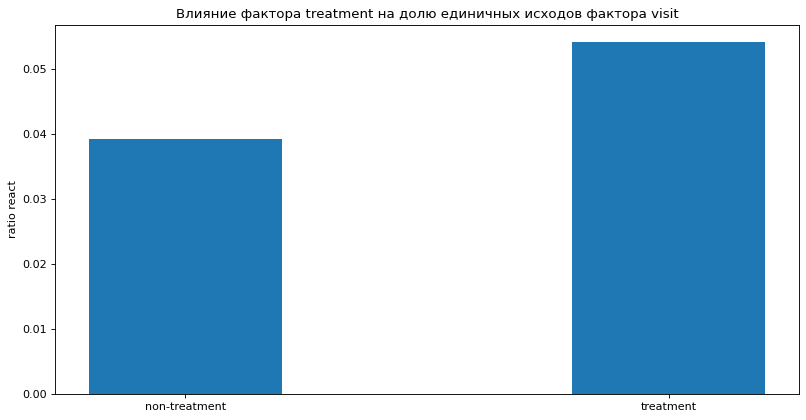

In [11]:
non_treat_v, treat_v = react('visit')

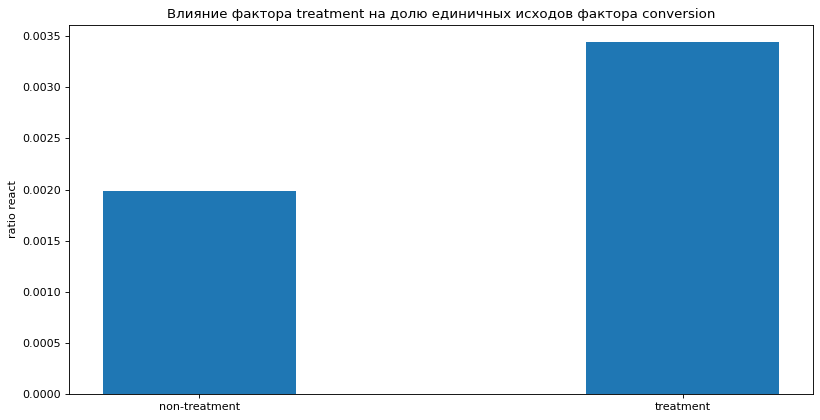

In [12]:
non_treat_c, treat_c = react('conversion')

In [13]:
df.groupby(['treatment', 'exposure'], as_index = False).agg({'f0':'count'})

,treatment,exposure,f0
0,0,0,2047888
1,1,0,10244240
2,1,1,427919


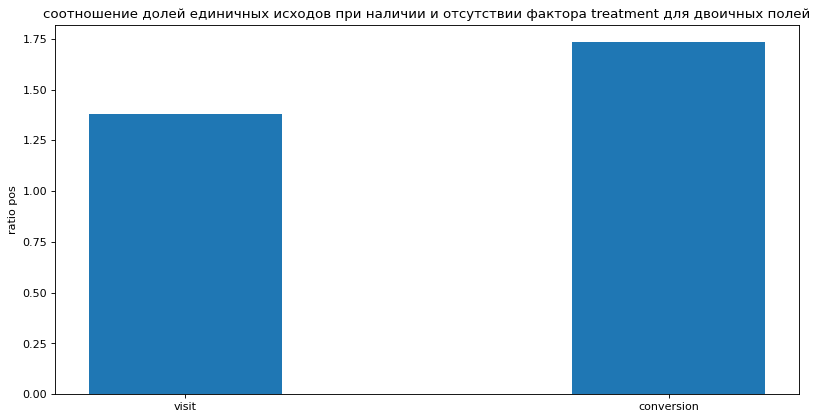

In [14]:
figure(figsize=(12, 6), dpi=80)
y = [treat_v/non_treat_v, treat_c/non_treat_c]
x = ['visit', 'conversion']
plt.ylabel('ratio pos')
plt.title('соотношение долей единичных исходов при наличии и отсутствии фактора treatment для двоичных полей')
plt.bar(x, y, width = 0.4) 
plt.show()

<div class="alert alert-info">
    В качестве претендента на отклика были рассмотрены присутствующие в таблице двоичные факторы. Фактор 'exposure' не может использоваться в качестве
отклика, так как для него отсутствуют положительные (единичные) исходы при отсутствии фактора treatment. Наиболее чувствителен к действию 'treatment'
фактор 'conversion', который под действием 'treatment' увеличивает долю положительных исходов в 1,75 раза, в то время, как фактор 'visit' под действием 
'treatment'повышает число единичных исходов только в 1,4 раза. Тем не менее, для фактора 'visit' величина доли положительных исходов в обеих выборках 
(tretment и non_treatment) на порядок выше, чем для фактора 'conversion'. Поэтому, в качестве функции отклика логично выбрать фактор 'visit', 
содержащий наиболее презентативное число единичных исходов.
 </div>

In [15]:
f = list(df.columns[:12])

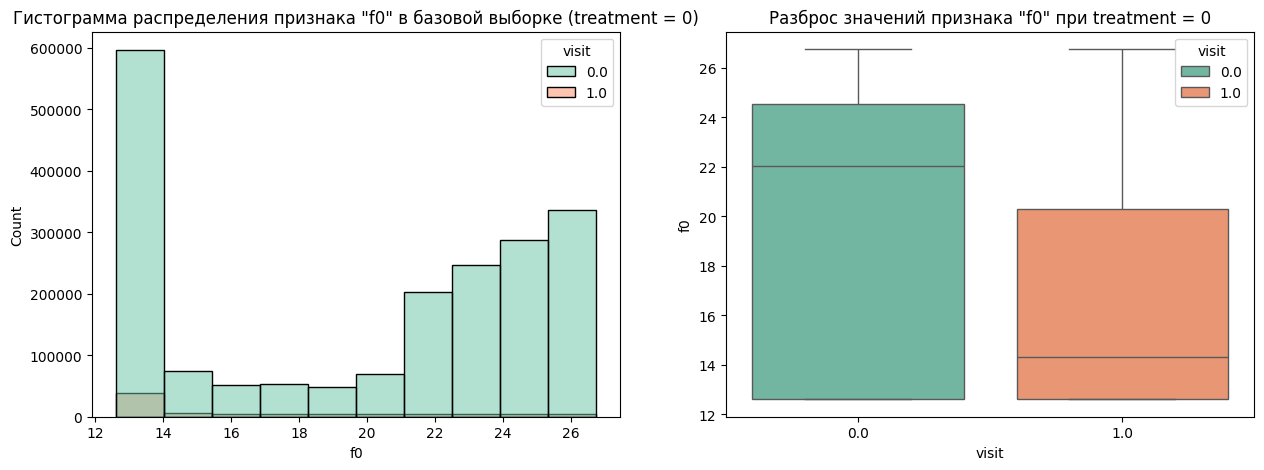

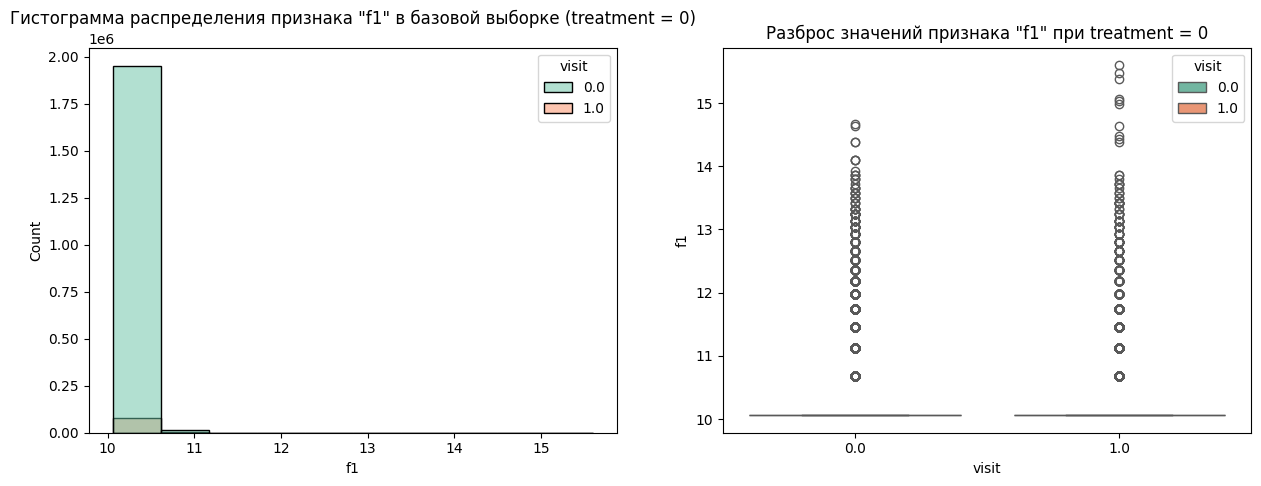

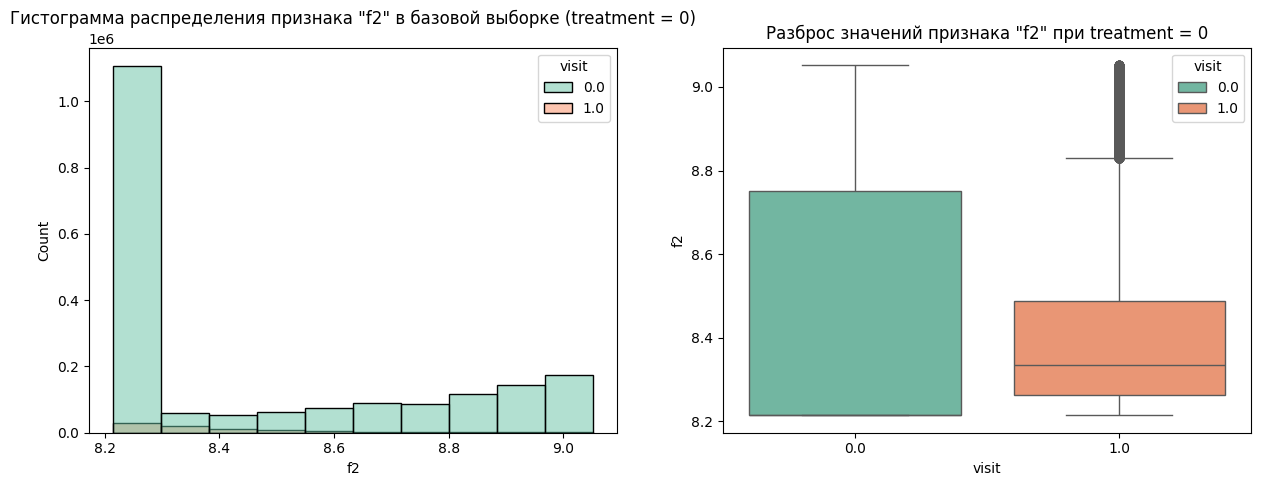

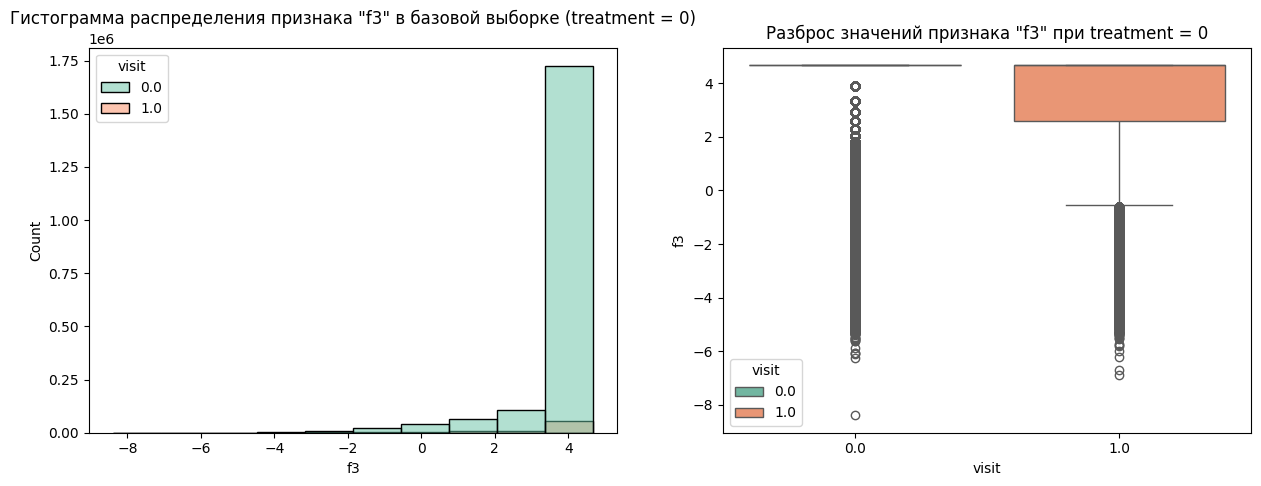

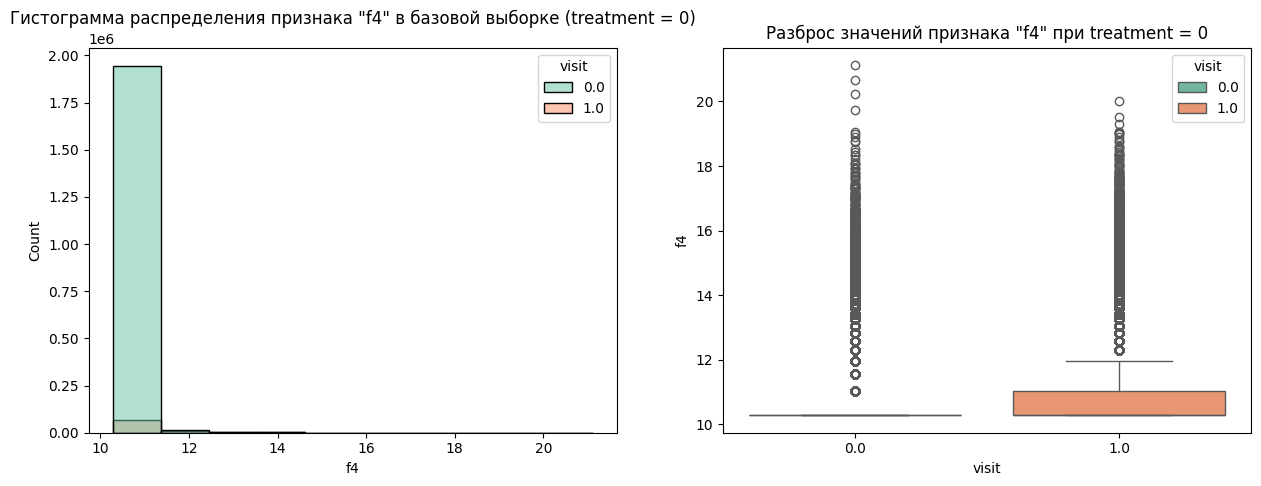

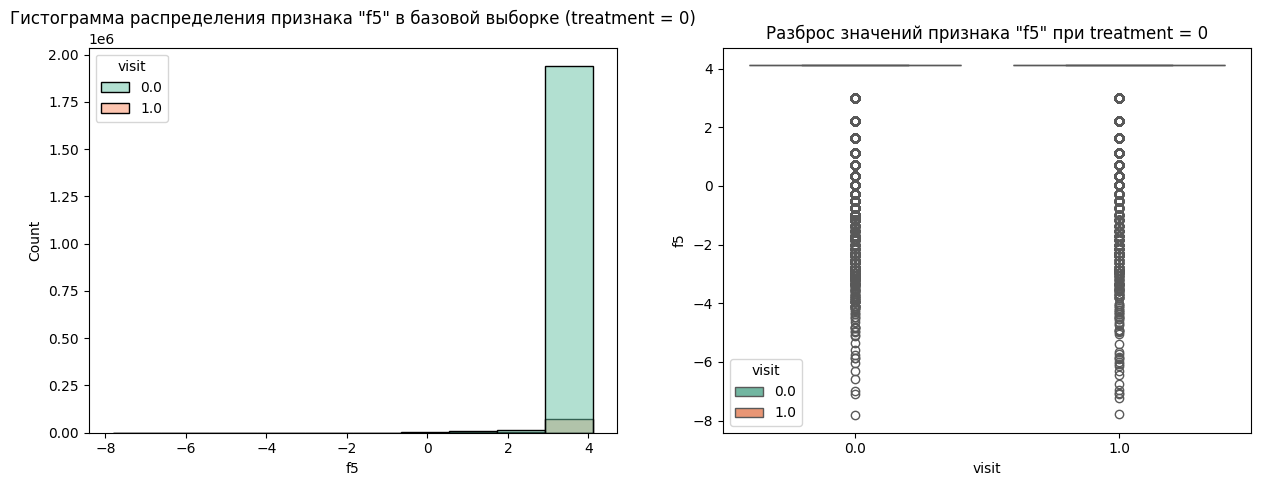

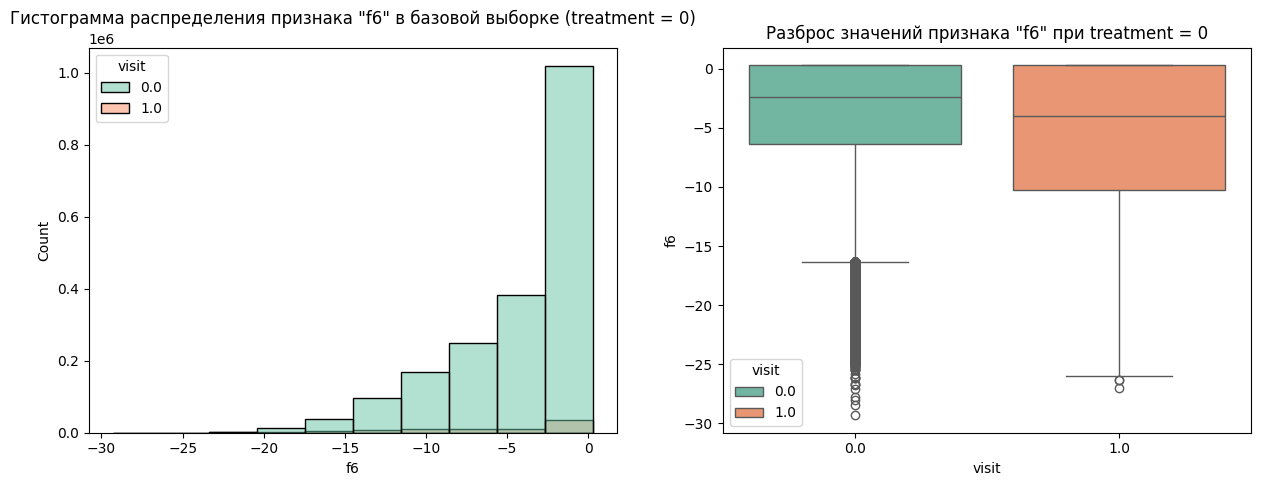

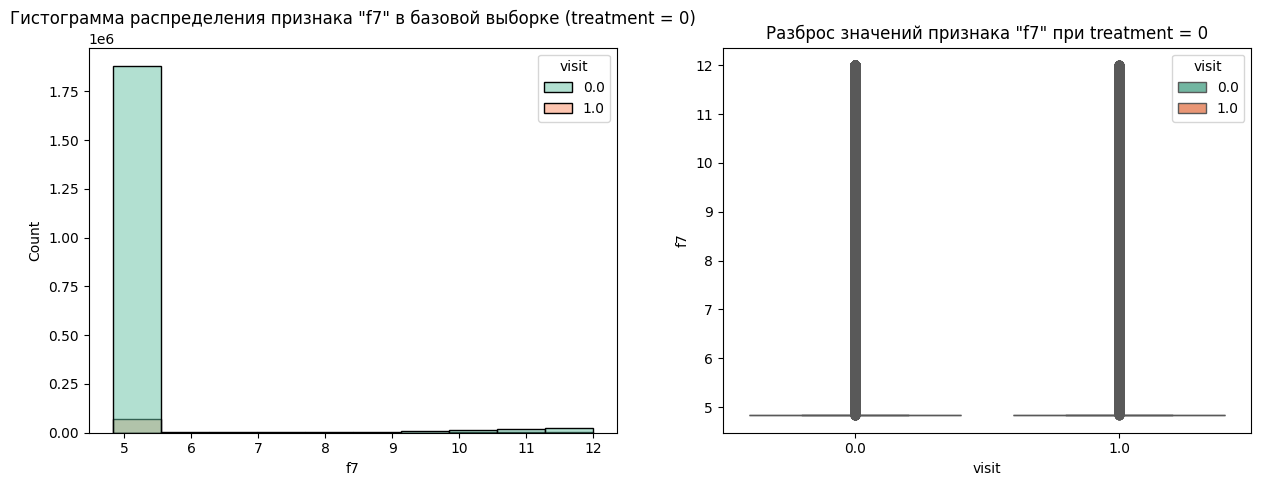

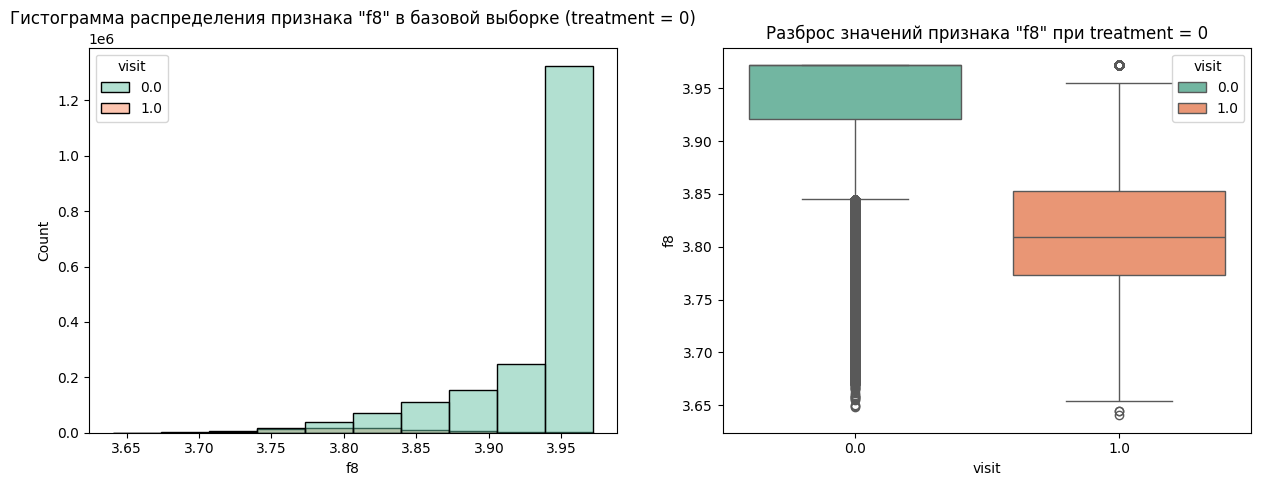

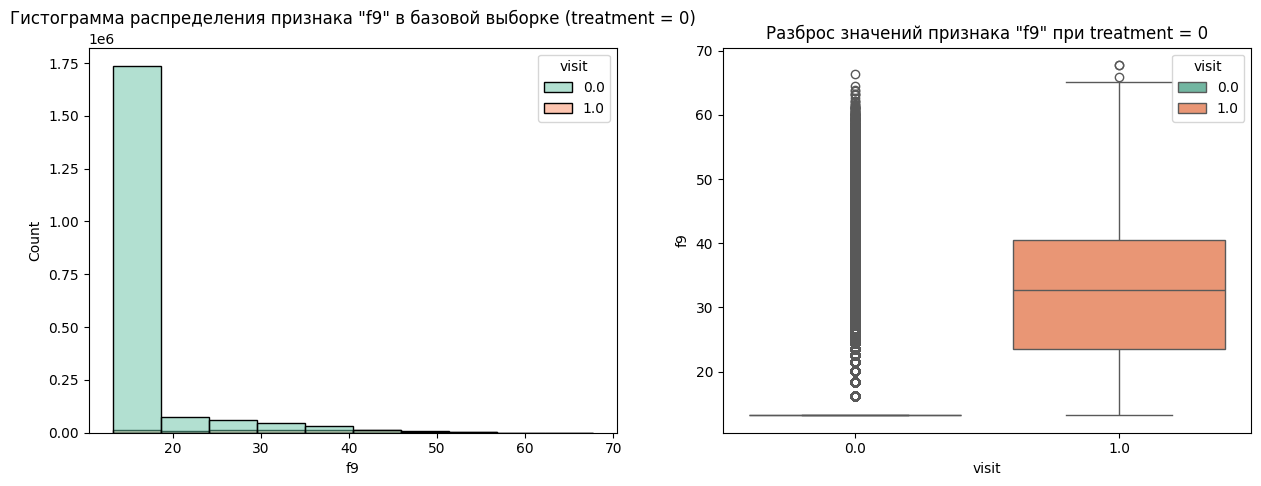

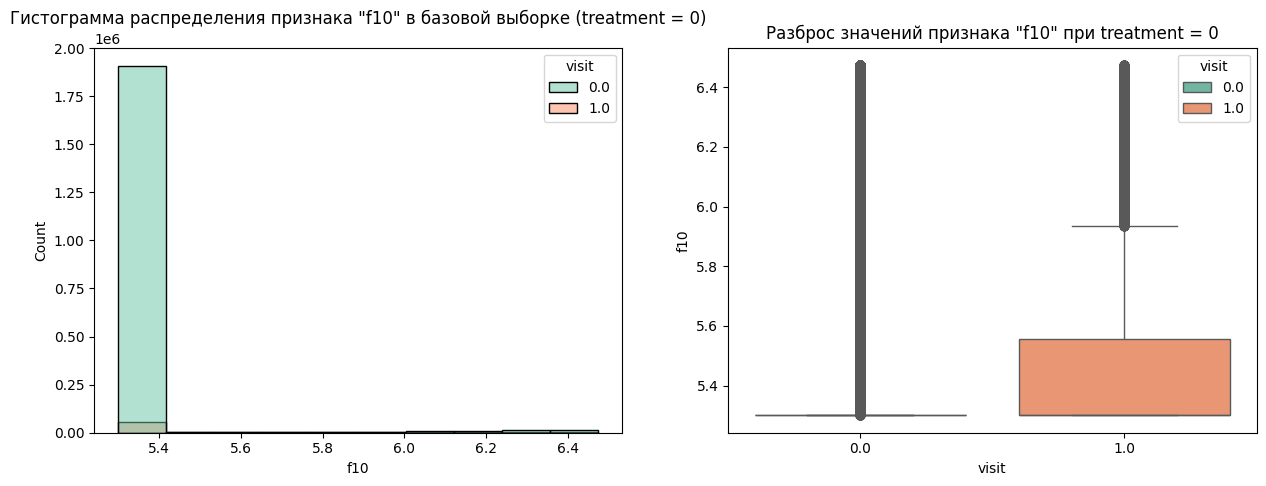

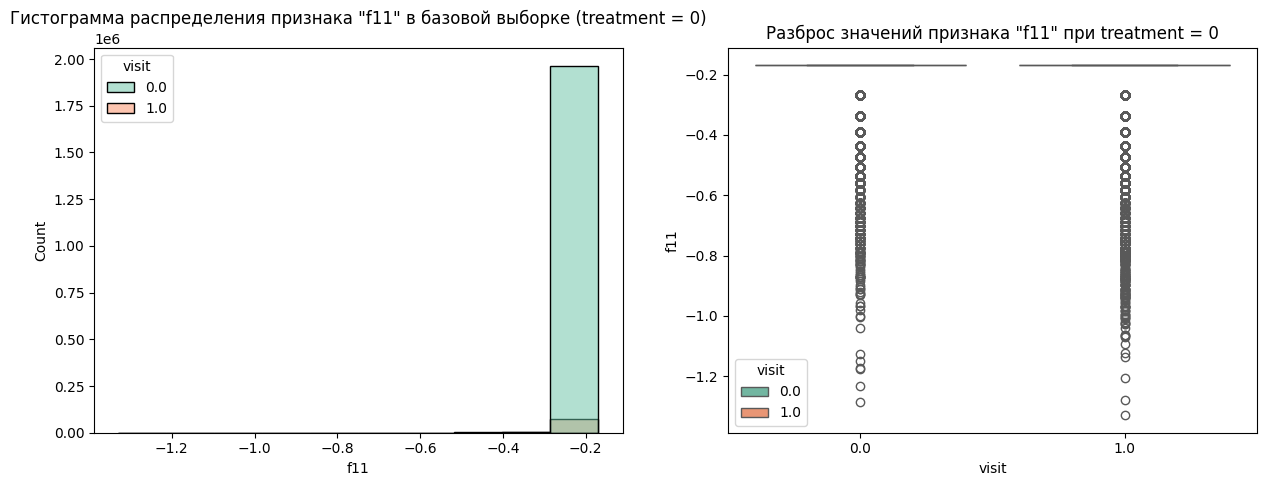

In [16]:
for i in f:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    sns.histplot(data = df.query('treatment == 0'), x = df[i], bins=10, ax=axes[0], hue = 'visit', palette="Set2")
    axes[0].set_title('Гистограмма распределения признака "{}" в базовой выборке (treatment = 0)'.format(i))
    sns.boxplot(data = df.query('treatment == 0'), y = df[i], x = 'visit', ax=axes[1], hue = 'visit', palette="Set2")
    axes[1].set_title('Разброс значений признака "{}" при treatment = 0'.format(i))
    plt.show()

<div class="alert alert-info">
    Для каждого непрерывного признака при отсутствии воздействия treatment были построены гистограммы и точечные распределения. Все распределения, 
кроме 'f0', характеризуются большим количеством выбросов. Кроме того, распределения данных фвкторов далеки от нормального. 
</div>

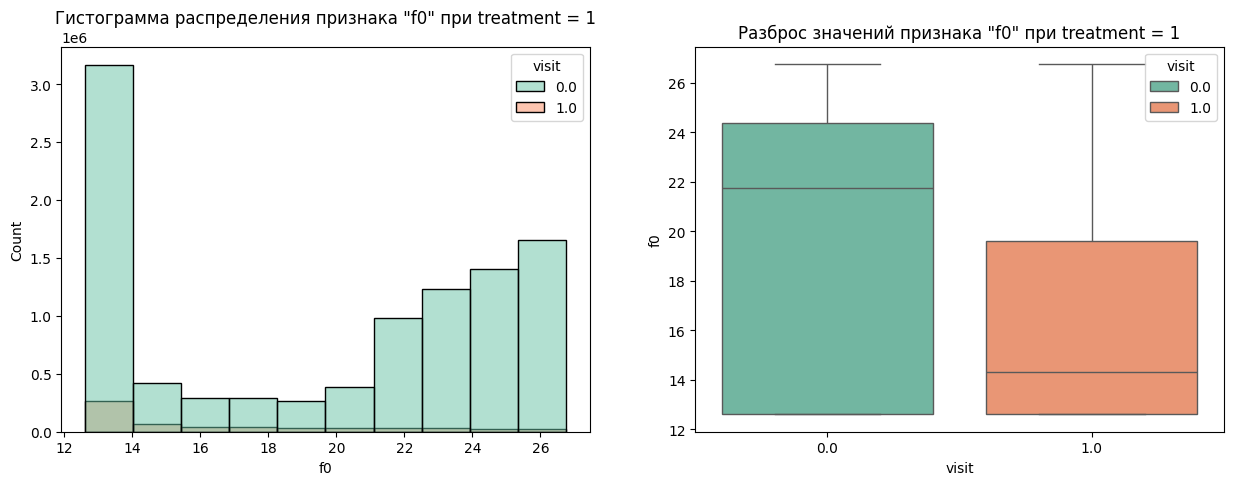

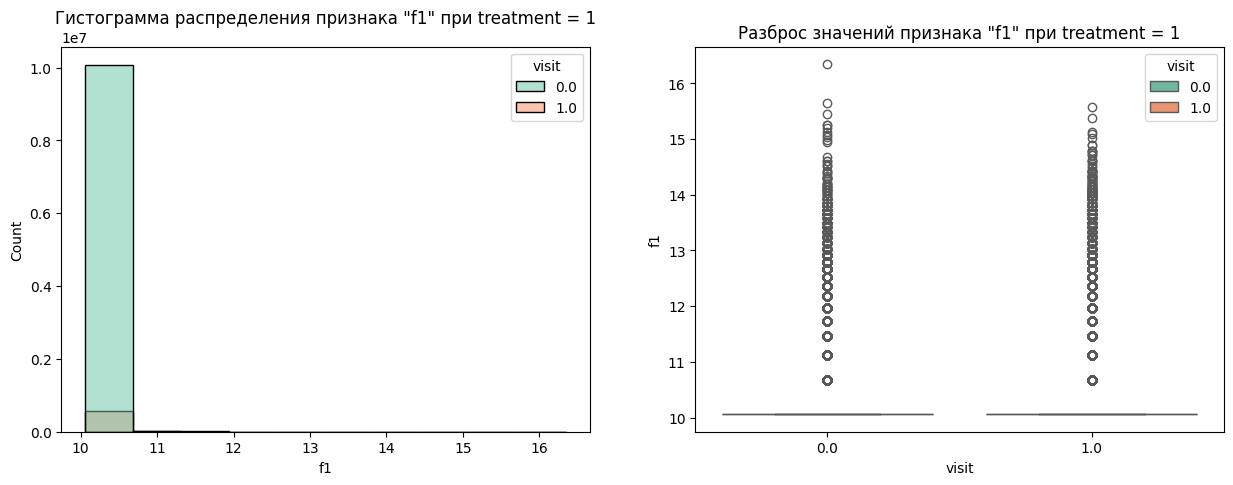

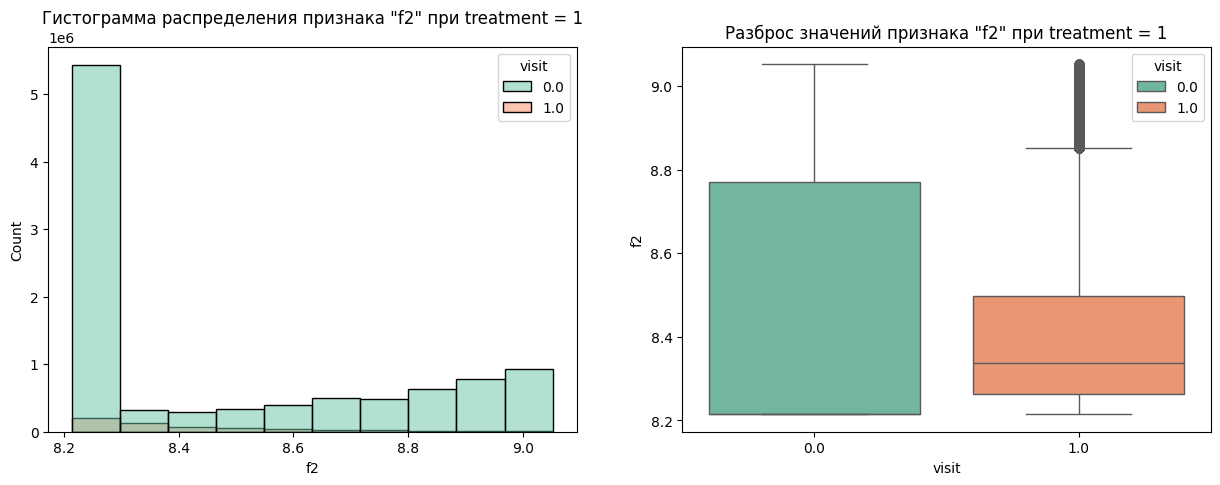

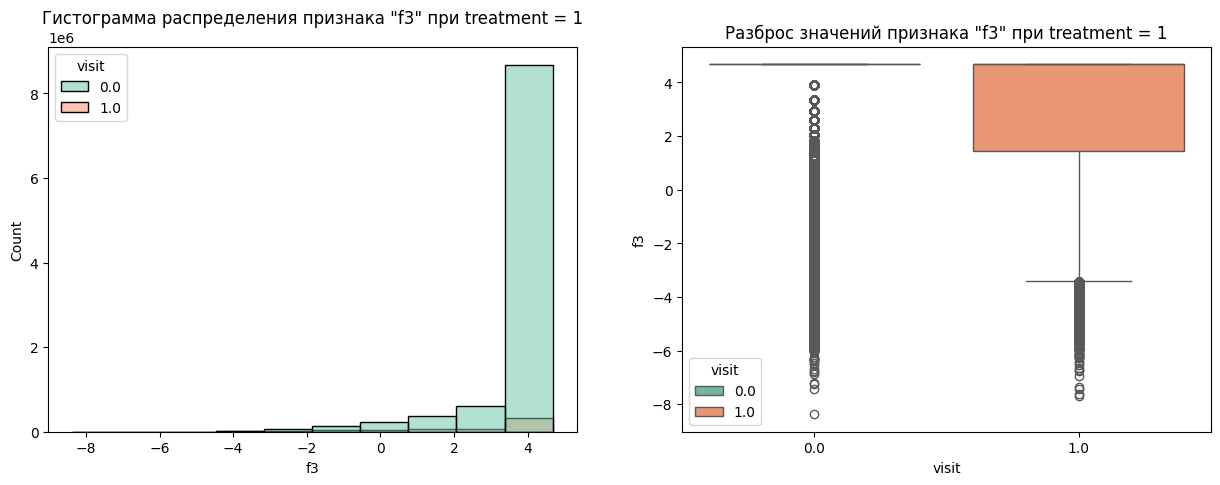

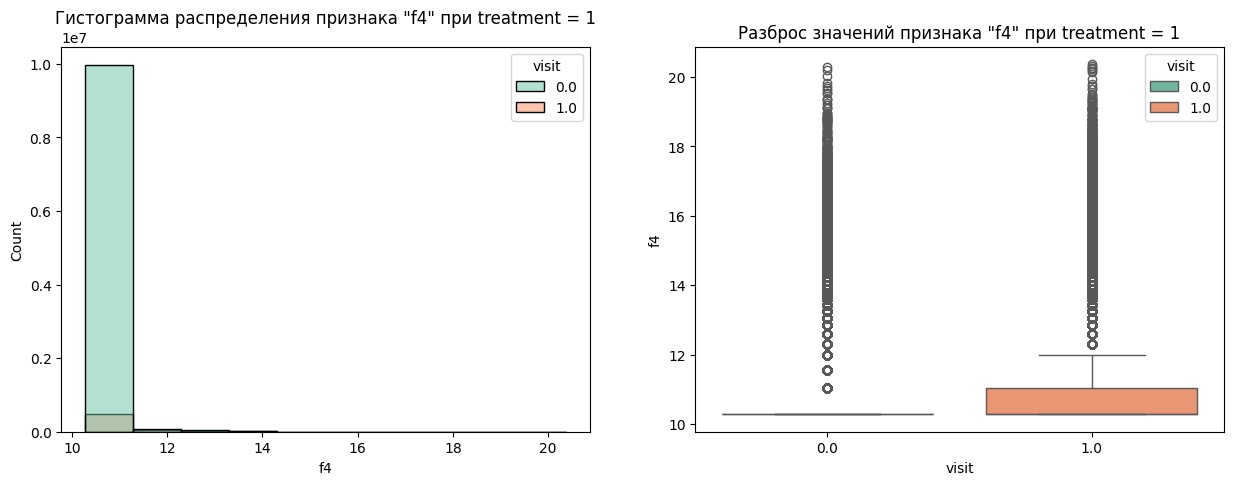

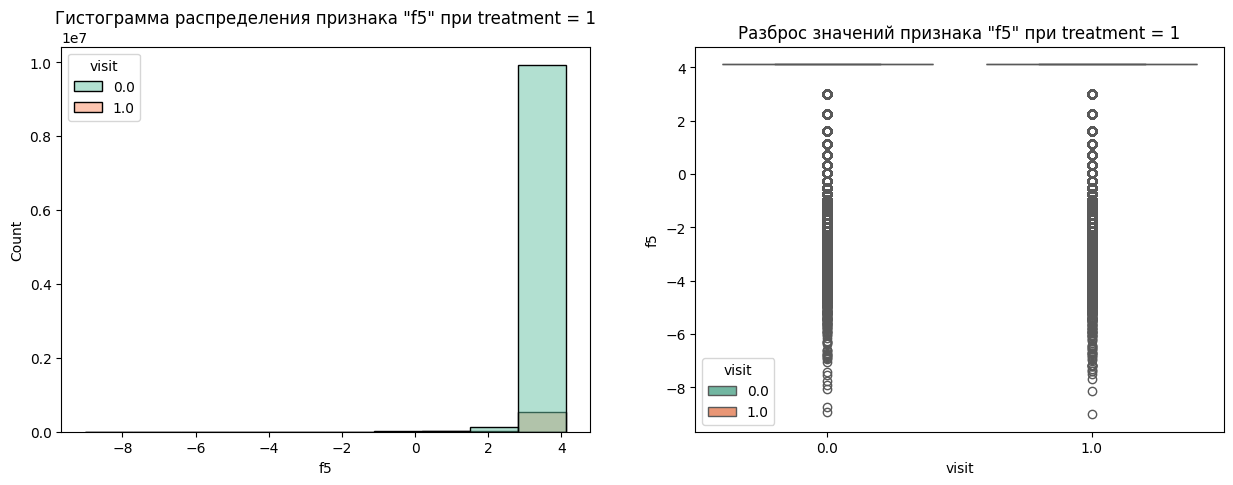

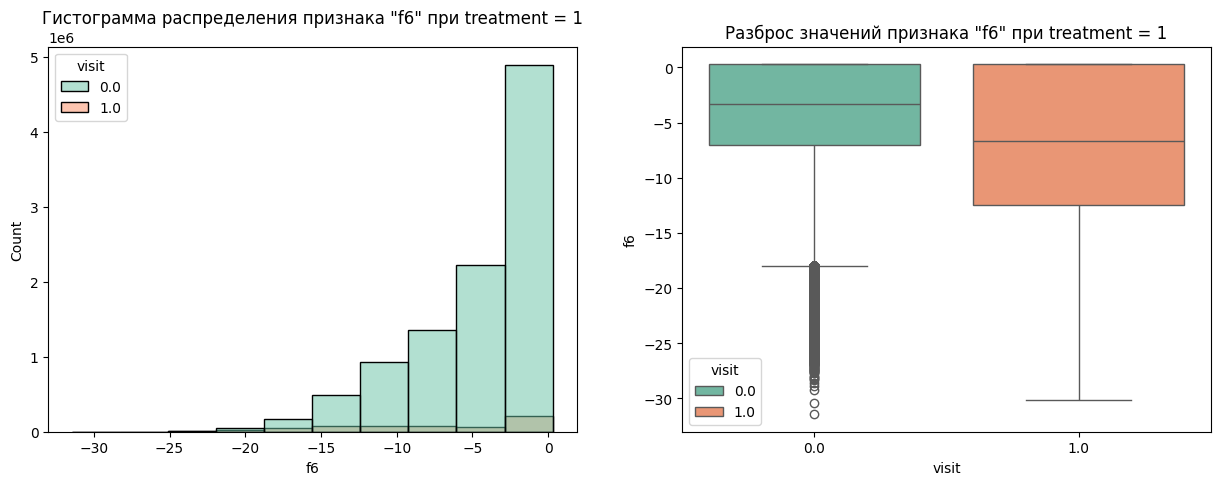

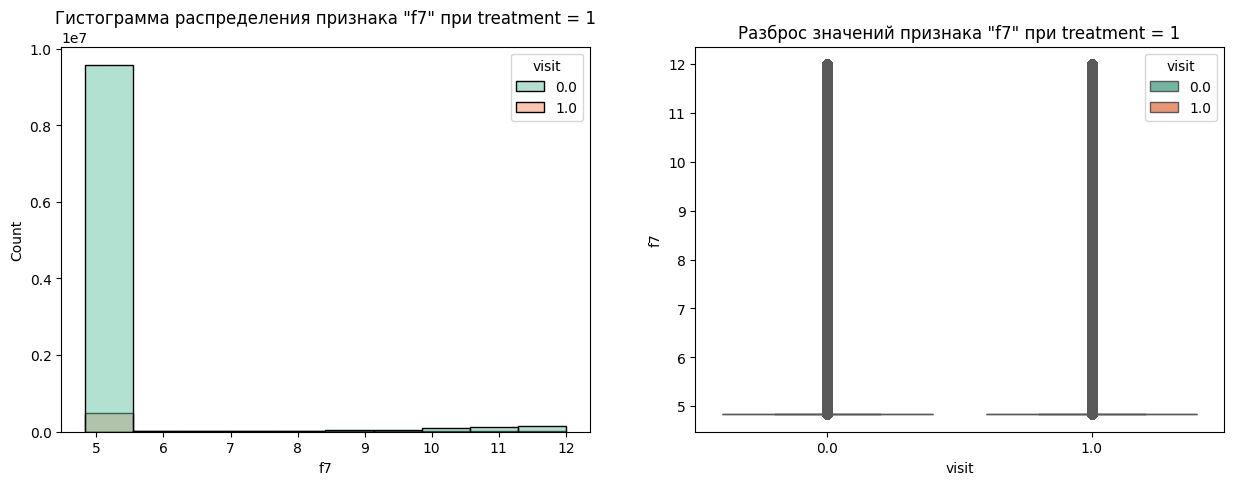

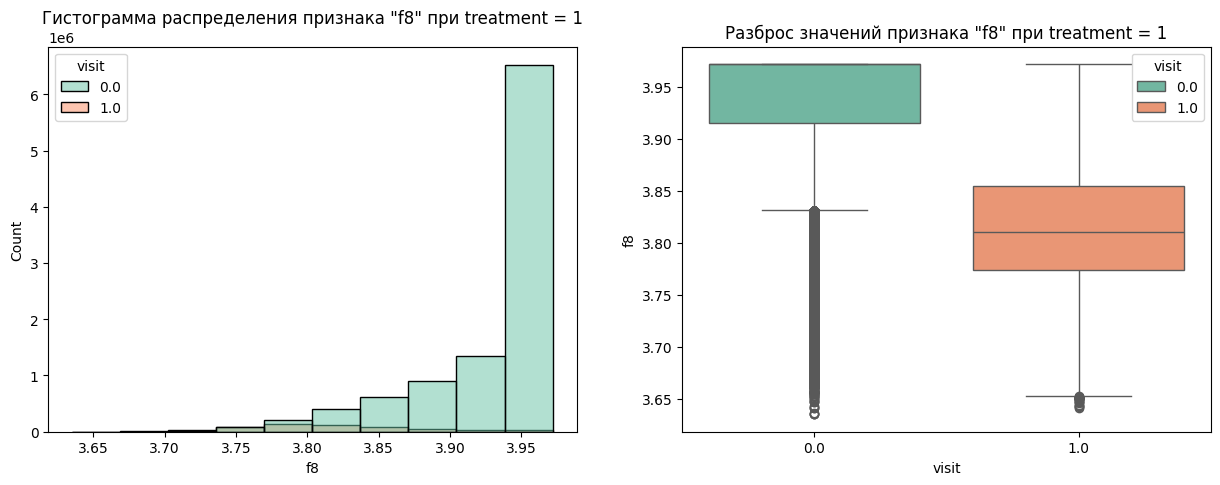

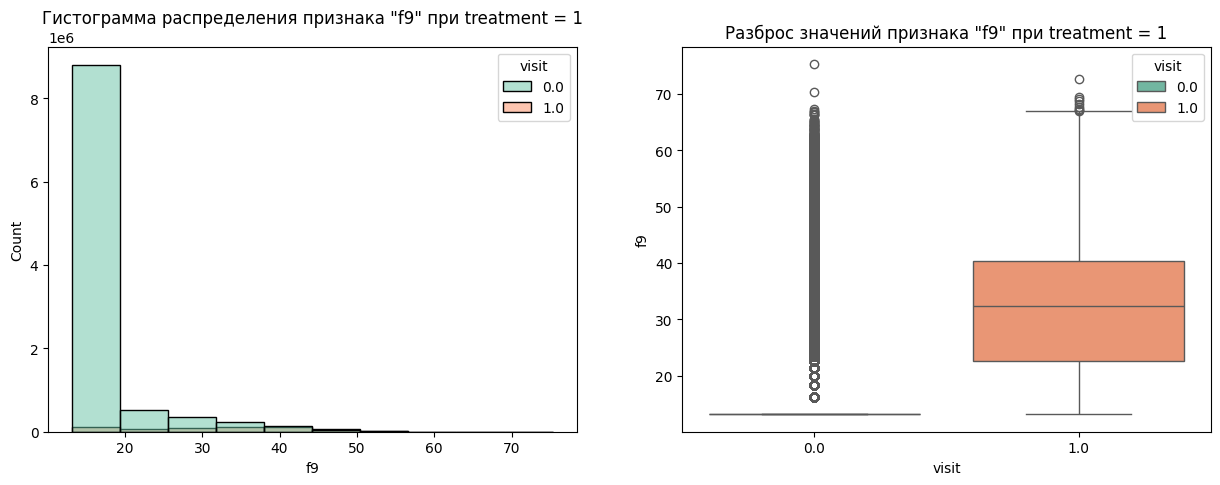

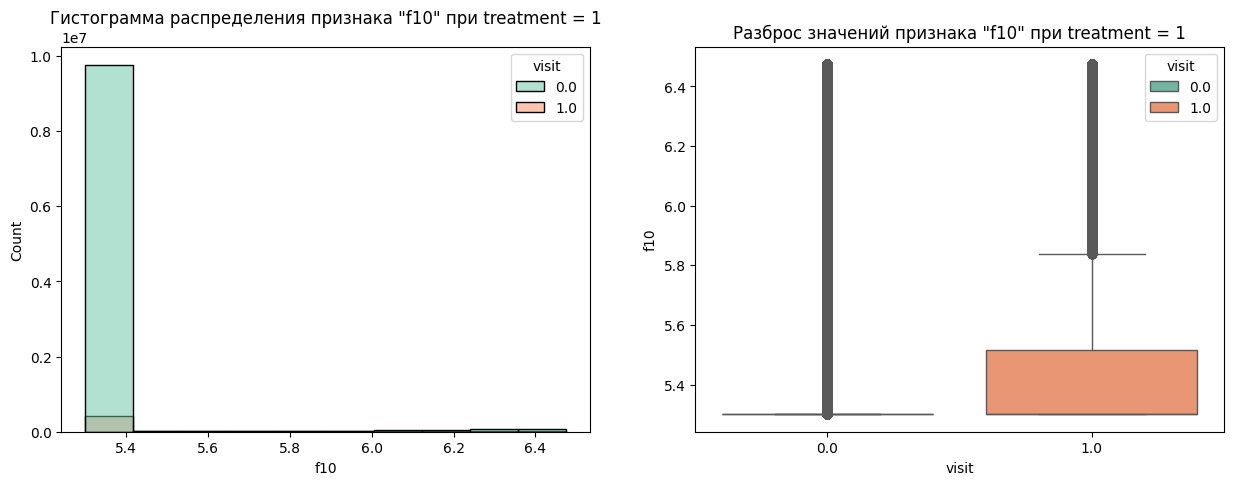

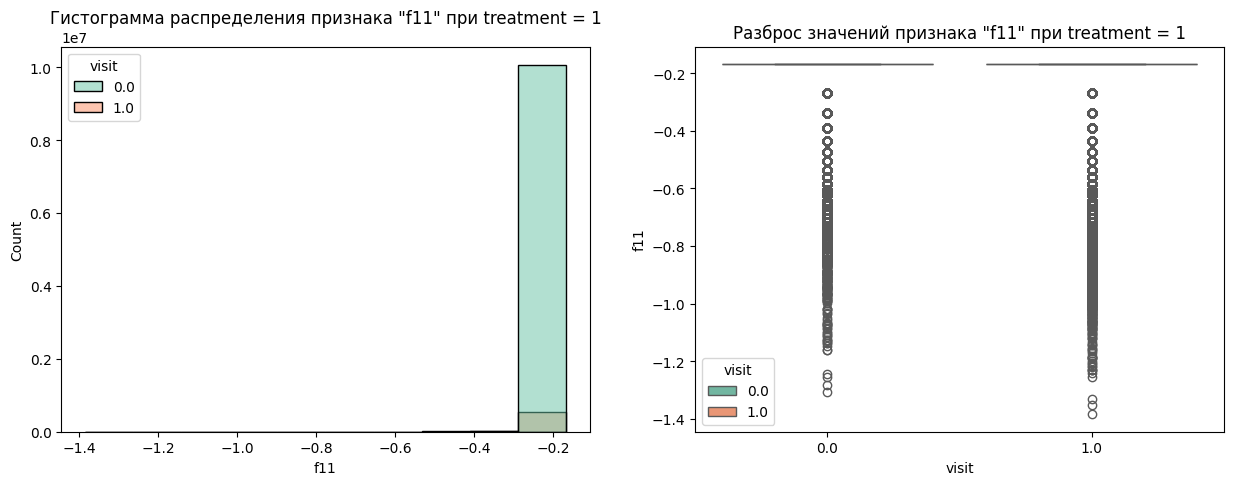

In [17]:
for i in f:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    sns.histplot(data = df.query('treatment == 1'), x = df[i], bins=10, ax=axes[0], hue = 'visit', palette="Set2")
    axes[0].set_title('Гистограмма распределения признака "{}" при treatment = 1'.format(i))
    sns.boxplot(data = df.query('treatment == 1'), y = df[i], x = 'visit', ax=axes[1], hue = 'visit', palette="Set2")
    axes[1].set_title('Разброс значений признака "{}" при treatment = 1'.format(i))
    plt.show()

<div class="alert alert-info">
    Характер распределения непрерывных признаков в выборке с treatment = 1 в обеих категориях (visit = 1 и visit = 0) остается таким же, как в
контрольной выборке. Факторы f1, f5, f7 и f11 имеют максимальное число выбросов и минимальный разброс значений в между 25 и 75 перцентилями, что
свидетельствует об их низкой потенциальной пригодности для моделирования. 
</div>

In [18]:
def med_non_treat(a):
    med = df.loc[(df['treatment']==0) & (df['visit'] == 1), a].median()
    return med.tolist()

In [19]:
def med_treat(a):
    med = df.loc[(df['treatment']==1) & (df['visit'] == 1), a].median()
    return med.tolist()

In [20]:
non_treat = [med_non_treat(i) for i in f]

In [21]:
treat = [med_treat(i) for i in f]

In [22]:
med = pd.DataFrame({'med_non_treat':non_treat, 'med_treat':treat, 'признаки':f})

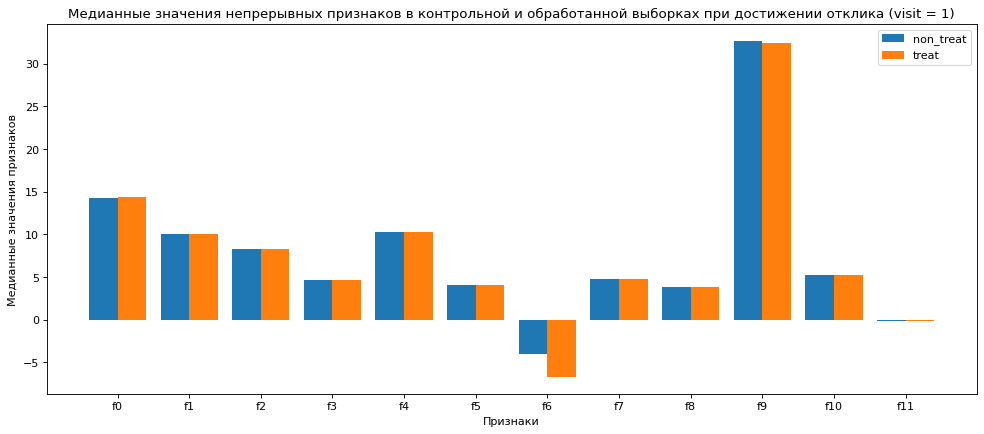

In [23]:
w, x = 0.4, np.arange(len(f))   
figure(figsize=(15, 6), dpi=80)
plt.bar(x - w/2, med['med_non_treat'], w, label='non_treat')    
plt.bar(x + w/2, med['med_treat'], w, label='treat')    
plt.xticks(x, f)  
plt.ylabel('Медианные значения признаков')  
plt.xlabel('Признаки') 
plt.title('Медианные значения непрерывных признаков в контрольной и обработанной выборках при достижении отклика (visit = 1)')  
plt.legend()  
plt.show()  

<div class="alert alert-info">
    Сравнение медианных значений непрерывных признаков в при достижении положительного отклика (vist = 1) в контрольной (treatment = 0) и обработанной
(treatment = 1) выборках показывает для большинства их практическую неизменность. Таким образом, процент положительного отклика в обработанной выборке
увеличивается, по сравнению с контрольной выборкой, по-видимому, за счет увеличения абсолютного значения медианы признака 'f6' и небольшого снижения 
медианы признака 'f9'. 
</div>

## Исследование взаимной корреляции признаков
<a id="start2"></a>

In [24]:
df['f0'].corr(df['f1']).tolist()

-0.08524432325135632

In [25]:
correlation_matrix = df[f].corr()

In [26]:
correlation_matrix

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11
f0,1.000000,-0.085244,-0.484545,0.275174,-0.088669,0.046080,-0.299354,0.010908,0.390253,-0.284667,-0.084486,0.076804
f1,-0.085244,1.000000,-0.018287,-0.328641,0.148037,-0.573800,-0.190994,0.149619,-0.140562,0.171957,0.067966,-0.149482
f2,-0.484545,-0.018287,1.000000,0.023671,0.015883,-0.013257,0.206894,0.025841,-0.353471,-0.074693,0.079850,0.037268
f3,0.275174,-0.328641,0.023671,1.000000,-0.196047,0.330473,0.546122,-0.199403,0.268875,-0.294852,-0.131943,0.170030
f4,-0.088669,0.148037,0.015883,-0.196047,1.000000,-0.194613,-0.154822,0.109925,-0.409064,0.361958,0.657431,-0.677760
f5,0.046080,-0.573800,-0.013257,0.330473,-0.194613,1.000000,0.359521,-0.745380,0.194077,-0.153974,-0.124562,0.120442
f6,-0.299354,-0.190994,0.206894,0.546122,-0.154822,0.359521,1.000000,-0.319363,0.095640,-0.091954,-0.118504,0.086244
f7,0.010908,0.149619,0.025841,-0.199403,0.109925,-0.745380,-0.319363,1.000000,-0.133239,0.079878,0.093088,-0.048119
f8,0.390253,-0.140562,-0.353471,0.268875,-0.409064,0.194077,0.095640,-0.133239,1.000000,-0.747303,-0.401597,0.252486
f9,-0.284667,0.171957,-0.074693,-0.294852,0.361958,-0.153974,-0.091954,0.079878,-0.747303,1.000000,0.265010,-0.362491


<div class="alert alert-info">
    Матрица корреляции признаков показывает практическое отсутствие взаимной корреляции. Наибольшие коэффициенты корреляции в следующих парах: 
f9 и f8 (-0,75), f4 и f10 (0,66). 
</div>

## Бинаризация признаков, вычисление WoE, IV, NWoE и NIV
<a id="start3"></a>

In [161]:
df_treat = df.query('treatment == 1')

In [162]:
df_non_treat = df.query('treatment == 0')

In [261]:
def calc(a, b):
    df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
    df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
    db_treat = df_treat.groupby('a_bin', as_index = False).agg({'visit':'sum'}).merge(df_treat.groupby('a_bin', as_index = False).agg({'visit':'count'}), on = 'a_bin')
    db_non_treat = df_non_treat.groupby('a_bin', as_index = False).agg({'visit':'sum'}).merge(df_non_treat.groupby('a_bin', as_index = False).agg({'visit':'count'}), on = 'a_bin')
    db_treat['visit_zero'] = db_treat['visit_y'] - db_treat['visit_x']
    db_non_treat['visit_zero'] = db_non_treat['visit_y'] - db_non_treat['visit_x']
    db_treat = db_treat.drop('visit_y', axis = 1)
    db_non_treat = db_non_treat.drop('visit_y', axis = 1)
    db_treat['ratio_plus'] = db_treat['visit_x']/(sum(db_treat['visit_x']))
    db_treat['ratio_mine'] = db_treat['visit_zero']/(sum(db_treat['visit_zero']))
    db_non_treat['ratio_plus'] = db_non_treat['visit_x']/(sum(db_non_treat['visit_x']))
    db_non_treat['ratio_mine'] = db_non_treat['visit_zero']/(sum(db_non_treat['visit_zero']))
    db_treat['WOE'] = np.log(db_treat['ratio_plus']/db_treat['ratio_mine'])
    db_non_treat['WOE'] = np.log(db_non_treat['ratio_plus']/db_non_treat['ratio_mine'])
    db_treat['IV_w'] = (db_treat['ratio_plus'] - db_treat['ratio_mine'])*db_treat['WOE']
    db_non_treat['IV_w'] = (db_non_treat['ratio_plus'] - db_non_treat['ratio_mine'])*db_non_treat['WOE']
    IV_treat = sum(db_treat['IV_w'])
    IV_non_treat = sum(db_non_treat['IV_w'])
    db_sum = db_treat.merge(db_non_treat, on = 'a_bin')
    db_sum['NWOE'] = db_sum['WOE_x'] - db_sum['WOE_y'] 
    db_sum = db_sum[['a_bin', 'WOE_x', 'WOE_y','NWOE']]
    NIV = IV_treat - IV_non_treat
    return db_sum, IV_treat, IV_non_treat, NIV

In [367]:
NWOE_f0, IV_treat_f0, IV_non_treat_f0, NIV_f0 = calc('f0', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [368]:
IV_treat_f0, IV_non_treat_f0, NIV_f0

(0.5466161502417197, 0.5129162743878357, 0.03369987585388401)

In [369]:
NWOE_f0

,a_bin,WOE_x,WOE_y,NWOE
0,"(12.602, 14.971]",0.456879,0.480232,-0.023353
1,"(14.971, 17.326]",0.896473,0.854662,0.041811
2,"(17.326, 19.681]",0.688545,0.741939,-0.053394
3,"(19.681, 22.036]",0.046307,0.100133,-0.053826
4,"(22.036, 24.39]",-0.908180,-0.847632,-0.060549
5,"(24.39, 26.745]",-1.325515,-1.190756,-0.134759


<div class="alert alert-info">
    Создана функция для бинаризации каждого признака с разбиением диапазона значений равные интервалы. Объекты изначально были разделены на 2 выборки:
обработанная (treatment = 1) и контрорльная (treatment = 0)). Каждую из этих выборок функция calc() на несколько бинов (10-20), затем рассчитывает 
коэффициенты весовые коэффициенты для каждого бина (WOE) и информационную ценность признака (IV) для каждой выборки. После этого определяется разница 
между коэффициентами WOE для обработанной и контрольной выборок (NWOE), а также определяется изменение информационной ценности признака при переходе
от контрольной к обработанной группам (NIV). 
</div>

<div class="alert alert-info">
    Для признака 'f0' выборки разбиты на 6 бинов, найденные для которых значения WOE изменяются практически монотонно. Величина IV обработанной 
выборки (0,54) превышает IV контрольной (0,51), то есть в обработанной выборке информационная ценность признака 'f0' повышается. Данный признак
имеет высокий предсказательный потенциал, который превышает 0,5 (подозрительно высокий). 
</div>

In [370]:
NWOE, IV_treat_f1, IV_non_treat_f1, NIV_f1 = calc('f1', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [371]:
IV_treat_f1, IV_non_treat_f1, NIV_f1

(0.05302479080455164, 0.029241076850487754, 0.02378371395406389)

<div class="alert alert-info">
    Признак 'f1' малополезен для моделирования из-за низких значений IV в обеих выборках (менее 0,1). При переходе к обработанной выборке 
ценность 'f1' незначительно повышается.
</div>

In [372]:
NWOE, IV_treat_f2, IV_non_treat_f2, NIV_f2 = calc('f2', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [373]:
IV_treat_f2, IV_non_treat_f2, NIV_f2

(0.5282371406617903, 0.5473932468443539, -0.01915610618256358)

<div class="alert alert-info">
    Признак 'f2' немного снижает информационную ценность в обработанной выборке (NIV = -0.02). Значимость 'f2' для моделирования высокая.
</div>

In [374]:
NWOE, IV_treat_f3, IV_non_treat_f3, NIV_f3 = calc('f3', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [375]:
IV_treat_f3, IV_non_treat_f3, NIV_f3

(0.42871389687972355, 0.21418202846865803, 0.21453186841106553)

<div class="alert alert-info">
    Признак 'f3' существенно наращивает информационную ценность в обработанной выборке (NIV = 0,21). Значимость 'f3' для моделирования высокая.
</div>

In [376]:
NWOE, IV_treat_f4, IV_non_treat_f4, NIV_f4 = calc('f4', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [377]:
IV_treat_f4, IV_non_treat_f4, NIV_f4

(0.2746602269390143, 0.2587249596516091, 0.01593526728740524)

<div class="alert alert-info">
    Признак 'f4' несущественно наращивает информационную ценность в обработанной выборке (NIV = 0,015). Значимость 'f4' для моделирования средняя.
</div>

In [378]:
NWOE_f5, IV_treat_f5, IV_non_treat_f5, NIV_f5 = calc('f5', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [379]:
IV_treat_f5, IV_non_treat_f5, NIV_f5

(0.09639756875825893, 0.052646818865416015, 0.043750749892842916)

<div class="alert alert-info">
    Признак 'f5' несущественно наращивает информационную ценность в обработанной выборке (NIV = 0,04). Значимость 'f5' для моделирования низкая.
</div>

In [380]:
NWOE_f6, IV_treat_f6, IV_non_treat_f6, NIV_f6 = calc('f6', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [381]:
IV_treat_f6, IV_non_treat_f6, NIV_f6

(0.358646425704155, 0.18007535729032173, 0.17857106841383327)

<div class="alert alert-info">
    Признак 'f6' увеличивает информационную ценность в обработанной выборке (NIV = 0,18). Значимость 'f6' для моделирования умеренная.
</div>

In [382]:
NWOE_f7, IV_treat_f7, IV_non_treat_f7, NIV_f7 = calc('f7', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [383]:
IV_treat_f7, IV_non_treat_f7, NIV_f7

(0.1657556745607602, 0.09371508188014056, 0.07204059268061964)

<div class="alert alert-info">
    Признак 'f7' увеличивает информационную ценность в обработанной выборке (NIV = 0,07). Значимость 'f6' для моделирования низкая.
</div>

In [390]:
NWOE_f8, IV_treat_f8, IV_non_treat_f8, NIV_f8 = calc('f8', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [391]:
IV_treat_f8, IV_non_treat_f8, NIV_f8

(3.071100077436753, 3.319446919448389, -0.24834684201163615)

<div class="alert alert-info">
    Признак 'f8' создает слишком сильное влияние на результат, и его необходимо исключить из рассмотрения 
</div>

In [398]:
NWOE_f9, IV_treat_f9, IV_non_treat_f9, NIV_f9 = calc('f9', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [399]:
IV_treat_f9, IV_non_treat_f9, NIV_f9

(2.315973387984233, 2.580106771751916, -0.26413338376768314)

<div class="alert alert-info">
    Признак 'f9' создает слишком сильное влияние на результат, и его необходимо исключить из рассмотрения 
</div>

In [400]:
NWOE_f10, IV_treat_f10, IV_non_treat_f10, NIV_f10 = calc('f10', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [401]:
IV_treat_f10, IV_non_treat_f10, NIV_f10

(0.5298284919190409, 0.578624606073037, -0.048796114153996095)

<div class="alert alert-info">
    Признак 'f10' снижает ценность в обработанной выборке (NIV = -0.05) и, в целом, имеет сльное влияние на модель. 
</div>

In [402]:
NWOE_f11, IV_treat_f11, IV_non_treat_f11, NIV_f11 = calc('f11', 6)

C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_treat['a_bin'] = pd.cut(df_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_treat['a_bin'] = pd.cut(df_non_treat[a], bins=b)
C:\Users\79284\AppData\Local\Temp\ipykernel_18540\1957314472.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of panda

In [403]:
IV_treat_f11, IV_non_treat_f11, NIV_f11

(0.1206093021399035, 0.14520145421687447, -0.024592152076970977)

<div class="alert alert-info">
    Признак 'f11' снижает ценность в обработанной выборке (NIV = -0.024) и, в целом, имеет среднее влияние на модель. 
</div>

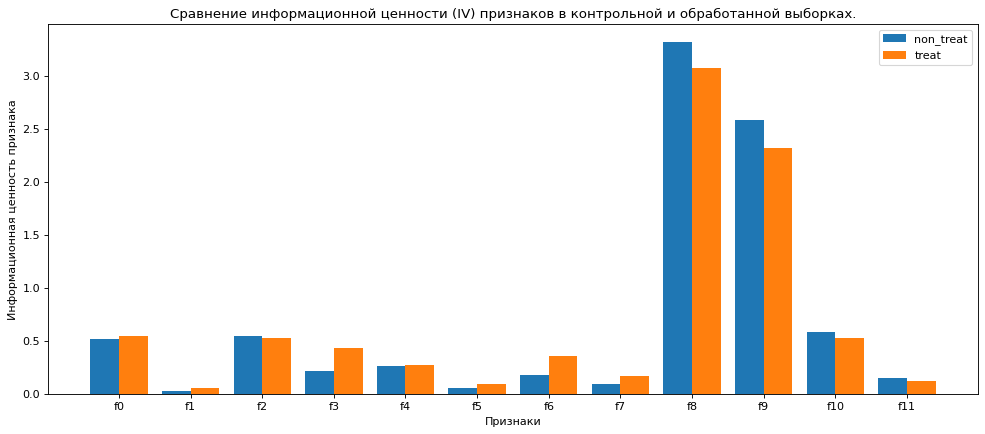

In [412]:
w, x = 0.4, np.arange(len(f))   
figure(figsize=(15, 6), dpi=80)
plt.bar(x - w/2, [IV_non_treat_f0, IV_non_treat_f1, IV_non_treat_f2, IV_non_treat_f3, IV_non_treat_f4, IV_non_treat_f5, IV_non_treat_f6, IV_non_treat_f7, IV_non_treat_f8, IV_non_treat_f9, IV_non_treat_f10, IV_non_treat_f11], w, label='non_treat')    
plt.bar(x + w/2, [IV_treat_f0, IV_treat_f1, IV_treat_f2, IV_treat_f3, IV_treat_f4, IV_treat_f5, IV_treat_f6, IV_treat_f7, IV_treat_f8, IV_treat_f9, IV_treat_f10, IV_treat_f11], w, label='treat')    
plt.xticks(x, f)  
plt.ylabel('Информационная ценность признака')  
plt.xlabel('Признаки') 
plt.title('Сравнение информационной ценности (IV) признаков в контрольной и обработанной выборках.')  
plt.legend()  
plt.show()  

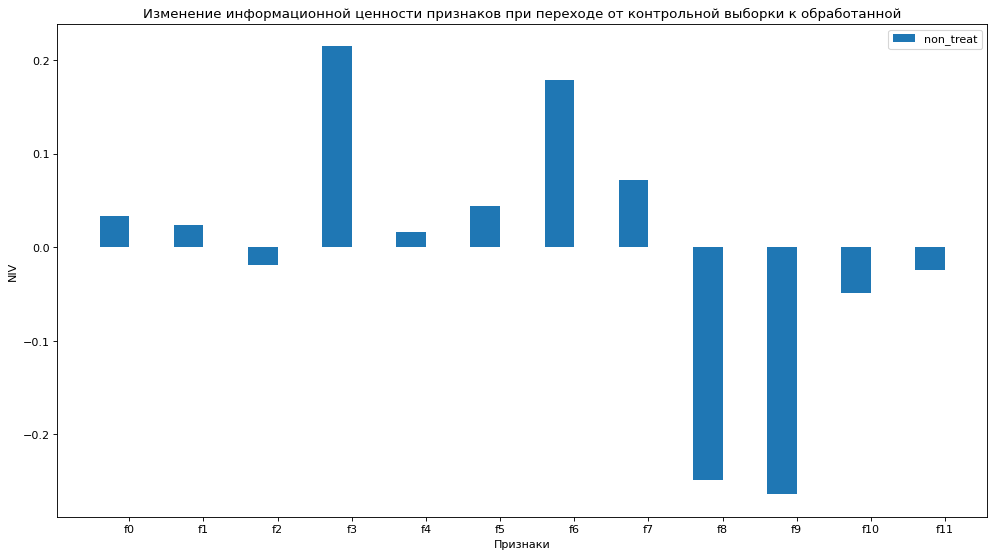

In [413]:
w, x = 0.4, np.arange(len(f))   
figure(figsize=(15, 8), dpi=80)
plt.bar(x - w/2, [NIV_f0, NIV_f1, NIV_f2, NIV_f3, NIV_f4, NIV_f5, NIV_f6, NIV_f7, NIV_f8, NIV_f9, NIV_f10, NIV_f11], w, label='non_treat')    
 
plt.xticks(x, f)  
plt.ylabel('NIV')  
plt.xlabel('Признаки') 
plt.title('Изменение информационной ценности признаков при переходе от контрольной выборки к обработанной')  
plt.legend()  
plt.show()  

<div class="alert alert-info
    Информационная ценность признаков при переходе от контрольной выборки к обработанной меняется разнонаправленно. NIV имеет положительное значение
для признаков f0, f1, f3, f4, f5, f6, f7 и отрицательные значения для f2, f8, f9, f10, f11. Наиболее сильно IV изменяется по модулю для признаков 
f3, f6, f8 и f9. Признаки f1 и f5 имеют слишком низкую информационную цненность (< 0,1) и могут быть исключены для моделирования. Признаки f8 и f9,
ннаоборот, имеют непропорционально высокое влияние на прогноз и также должны быть исключены. 
</div>

<div class="alert alert-info">
    Информационная ценность признаков при переходе от контрольной выборке к обработанной меняется разнонаправленно. Признаки f0, f1, f3, f4, f5, f6, f7
имеют положительное значение NIV, а признаки f2, f8, f9, f10, f11 - характеризуются отрицательным значением NIV. Признаки f1 и f5 имеют слишком низкую 
информационную ценность (IV < 0.1) и могут быть исключены из рассмотрения. Признаки f8 и f9, наоборот, имеют слишком высокую IV (>>0.5), и поэтому 
неприемлемы для моделирования.
</div>

## Выводы
<a id="start4"></a>

<div class="alert alert-info"> 
 
<b>Загрузка и проверка данных</b>

     Загруженная таблица содержит 16 столбцов, из которых 12 представлены данными типа float, а 4 - целочисленные. Пропусков данных в таблице нет.
Таблица содержит 1259545 дубликатов данных, которые были удалены. После удаления дубликатов осталось около 12,7 млн уникальных строк.

<b>Выявление полезного действия, как функции отклика на фактор treatment </b>

    В качестве претендента на отклика были рассмотрены присутствующие в таблице двоичные факторы. Фактор 'exposure' не может использоваться в качестве
отклика, так как для него отсутствуют положительные (единичные) исходы при отсутствии фактора treatment. Наиболее чувствителен к действию 'treatment'
фактор 'conversion', который под действием 'treatment' увеличивает долю положительных исходов в 1,75 раза, в то время, как фактор 'visit' под действием 
'treatment'повышает число единичных исходов только в 1,4 раза. Тем не менее, для фактора 'visit' величина доли положительных исходов в обеих выборках 
(tretment и non_treatment) на порядок выше, чем для фактора 'conversion'. Поэтому, в качестве функции отклика логично выбрать фактор 'visit', 
содержащий наиболее презентативное число единичных исходов.
    Для каждого непрерывного признака при отсутствии воздействия treatment были построены гистограммы и точечные распределения. Все распределения, 
кроме 'f0', характеризуются большим количеством выбросов. Кроме того, распределения данных фвкторов далеки от нормального. 
   Характер распределения непрерывных признаков в выборке с treatment = 1 в обеих категориях (visit = 1 и visit = 0) остается таким же, как в
контрольной выборке. Факторы f1, f5, f7 и f11 имеют максимальное число выбросов и минимальный разброс значений в между 25 и 75 перцентилями, что
свидетельствует об их низкой потенциальной пригодности для моделирования. 
    Сравнение медианных значений непрерывных признаков в при достижении положительного отклика (vist = 1) в контрольной (treatment = 0) и обработанной
(treatment = 1) выборках показывает для большинства их практическую неизменность. Таким образом, процент положительного отклика в обработанной выборке
увеличивается, по сравнению с контрольной выборкой, по-видимому, за счет увеличения абсолютного значения медианы признака 'f6' и небольшого снижения 
медианы признака 'f9'. 

<b> Исследование взаимной корреляции признаков </b>

  Матрица корреляции признаков показывает практическое отсутствие взаимной корреляции. Наибольшие коэффициенты корреляции в следующих парах: 
f9 и f8 (-0,75), f4 и f10 (0,66). 

<b> Бинаризация признаков, вычисление WoE, IV, NWoE и NIV </b>

   Создана функция для бинаризации каждого признака с разбиением диапазона значений равные интервалы. Объекты изначально были разделены на 2 выборки:
обработанная (treatment = 1) и контрорльная (treatment = 0)). Каждую из этих выборок функция calc() на несколько бинов (10-20), затем рассчитывает 
коэффициенты весовые коэффициенты для каждого бина (WOE) и информационную ценность признака (IV) для каждой выборки. После этого определяется разница 
между коэффициентами WOE для обработанной и контрольной выборок (NWOE), а также определяется изменение информационной ценности признака при переходе
от контрольной к обработанной группам (NIV). 
   Для признака 'f0' выборки разбиты на 6 бинов, найденные для которых значения WOE изменяются практически монотонно. Величина IV обработанной 
выборки (0,54) превышает IV контрольной (0,51), то есть в обработанной выборке информационная ценность признака 'f0' повышается. Данный признак
имеет высокий предсказательный потенциал, который превышает 0,5 (подозрительно высокий). 
     Информационная ценность признаков при переходе от контрольной выборке к обработанной меняется разнонаправленно. Признаки f0, f1, f3, f4, f5, f6, f7
имеют положительное значение NIV, а признаки f2, f8, f9, f10, f11 - характеризуются отрицательным значением NIV. Признаки f1 и f5 имеют слишком низкую 
информационную ценность (IV < 0.1) и могут быть исключены из рассмотрения. Признаки f8 и f9, наоборот, имеют слишком высокую IV (>>0.5), и поэтому 
неприемлемы для моделирования.